## Baseline for Slot1

## Check dataset existence

In [286]:
# check data existence
from pathlib import Path


data_folder = Path.cwd().parent.joinpath("data/processed")

def check_data_existence(folder):
    file_count = len(list(folder.glob("e*_ann.json")))
    if  file_count == 0:
        raise Exception("Processed Data does not exist.")
    else:
        print("{} files exist.".format(file_count))


check_data_existence(data_folder)

230 files exist.


## Read Slot1 data to DataFrame

In [307]:
# Slot1 predicts E#A label from entity and sentence
import json
import pandas as pd
from collections import Counter
from janome.tokenizer import Tokenizer


dataset = []
word_freq = Counter()
tokenizer = Tokenizer()
WINDOW_SIZE = 3
PAD = "__PAD__"
UNK = "__UNK__"


def format_word(word):
    if word.isdigit():
        return "0"
    else:
        return word

    
# convert 'from' 'to' to position on token
def convert_position(f, t, tokens):
    text = ""
    t_f = -1
    t_t = -1
    for i, x in enumerate(tokens):
        text += x.surface
        if t_f < 0 and len(text) > f:
            t_f = i
        if t_f >= 0 and t_t < 0 and len(text) > t:
            t_t = i
            break

    return t_f, t_t


def get_context(p, tokens):
    # forward context
    forward = []
    for i in range(p - 1, -1, -1):
        pos = tokens[i].part_of_speech.split(",")
        if pos[0] == "名詞":
            forward.append(tokens[i].surface)
            if len(forward) >= WINDOW_SIZE:
                break
    forward.reverse()
    forward = ([PAD] * WINDOW_SIZE + forward)[-WINDOW_SIZE:]
    
    # backward context
    backward = []
    for i in range(p + 1, len(tokens)):
        pos = tokens[i].part_of_speech.split(",")
        if pos[0] == "名詞":
            backward.append(tokens[i].surface)
            if len(forward) >= WINDOW_SIZE * 2:
                break
    backward = (backward + [PAD] * WINDOW_SIZE)[:WINDOW_SIZE]
    
    return forward, backward


for f in data_folder.glob("e*_ann.json"):
    with f.open(encoding="utf-8") as j:
        d = json.load(j)        
        for s in d["sentences"]:
            # register words
            tokenized = tokenizer.tokenize(s["sentence"])

            length = ""
            for o in s["opinions"]:
                targets = tokenizer.tokenize(o["target"])
                register_words(targets, target=True)

                # we need to convert position on str to position on word array
                f_t, t_t = convert_position(o["from"], o["to"], tokenized)
                
                # get context = before WINDOW_SIZE words + after WINDOW_SIZE words
                for t, p in zip(targets, range(f_t, t_t + 1)):
                    f_context, b_context = get_context(p, tokenized)
                    context = [format_word(x) for x in (f_context + b_context)]
                    
                    for w in context:
                        word_freq[w] += 1
                    word_freq[t.surface] += 1
                    
                    line = {
                        "label": o["category"],
                        "entity": o["category"].split("#")[0],
                        "attribute": o["category"].split("#")[1],
                        "target": t.surface,
                        "context":  context
                    }
                    dataset.append(line)

In [308]:
%matplotlib inline

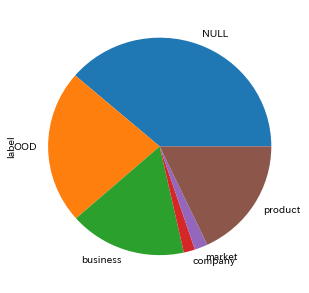

In [309]:
dataset = pd.DataFrame(dataset)
dataset.groupby("entity").count()["label"].plot.pie(figsize=(5, 5))

In [310]:
dataset.head(10)

,attribute,context,entity,label,target
0,general,"[経済, 米国, 中心, 堅調, 推移, 英国]",OOD,OOD#general,景気
1,general,"[確実, 性, 景気, 不透明, 状況, __PAD__]",OOD,OOD#general,先行き
2,general,"[__PAD__, __PAD__, __PAD__, 経済, 企業, 収益]",OOD,OOD#general,国内
3,general,"[__PAD__, __PAD__, 国内, 企業, 収益, 雇用]",OOD,OOD#general,経済
4,general,"[__PAD__, 国内, 経済, 収益, 雇用, 所得]",OOD,OOD#general,企業
5,general,"[国内, 経済, 企業, 雇用, 所得, 環境]",OOD,OOD#general,収益
6,general,"[経済, 企業, 収益, 所得, 環境, さ]",OOD,OOD#general,雇用
7,general,"[企業, 収益, 雇用, 環境, さ, 緩やか]",OOD,OOD#general,所得
8,general,"[収益, 雇用, 所得, さ, 緩やか, 回復]",OOD,OOD#general,環境
9,general,"[__PAD__, __PAD__, __PAD__, 業界, デジタル, 化]",market,market#general,歯科


In [311]:
dataset.groupby("label").count()["target"].sort_values(ascending=False)

label
OOD#general         4038
NULL#profit         2978
NULL#sales          2137
business#sales      1458
product#amount      1441
product#sales        975
NULL#cost            810
NULL#amount          731
product#general      677
business#profit      641
business#amount      391
business#general     369
market#general       338
NULL#price           177
company#sales         97
business#cost         85
company#amount        80
company#profit        61
business#price        54
product#price         54
company#general       40
product#profit        22
company#cost          11
product#cost          10
NULL#general           5
Name: target, dtype: int64

In [312]:
# Filter NULL / OOD entity
dataset = dataset[(dataset["entity"] != "NULL") & (dataset["entity"] != "OOD")]

In [313]:
# reset index from 0    
dataset.reset_index(drop=True, inplace=True)
# show dataset size
print("{} data is available.".format(len(dataset)))

6804 data is available.


In [314]:
dataset.head(5)

,attribute,context,entity,label,target
0,general,"[__PAD__, __PAD__, __PAD__, 業界, デジタル, 化]",market,market#general,歯科
1,general,"[__PAD__, __PAD__, 歯科, デジタル, 化, 進展]",market,market#general,業界
2,sales,"[当社, 注力, 分野, 品, ＣＡＤ, /]",product,product#sales,化工
3,sales,"[注力, 分野, 化工, ＣＡＤ, /, ＣＡＭ]",product,product#sales,品
4,sales,"[分野, 化工, 品, /, ＣＡＭ, 関連]",product,product#sales,ＣＡＤ


In [315]:
vocab = [PAD, UNK]
vocab_size = 5000

for term, freq in word_freq.most_common():
    if len(vocab) < vocab_size:
        vocab.append(term)
        
print("Vocabulary size is {} (less than {} frequency word is excluded)".format(len(vocab), min_freq))

Vocabulary size is 3437 (less than 3 frequency word is excluded)


## Prepare the word vector

In [316]:
# check pretrained vector existence
EMBED_SIZE = 300  # fastText is 300dim
word_vector_path = Path.cwd().joinpath("wiki.ja.vec")
if not word_vector_path.exists():
    raise Exception("Pre-trained word vector is not downloaded. Please execute download_fast_text.py.")

In [317]:
import numpy as np


embedding_matrix = np.zeros((len(vocab), EMBED_SIZE)) 

hit_count = -1
with word_vector_path.open(encoding="utf-8") as f:
    for line in f:
        if hit_count == -1:
            hit_count = 0
            continue  # skip first line that has (vocab_size, vector_size)

        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        if word in vocab:
            hit_count += 1
            index = vocab.index(word)
            embedding_matrix[index] = vector

print("load word embeddings ({} / {} is loaded).".format(hit_count, len(vocab)))

load word embeddings (3007 / 3437 is loaded).


## Make Baseline Model

* Baseline Model predicts the label from concatenated vector of context & target.


In [318]:
labels = sorted(dataset.groupby("label").groups.keys())
entity_labels = sorted(dataset.groupby("entity").groups.keys())
attribute_labels = sorted(dataset.groupby("attribute").groups.keys())
print("Label count is {}.".format(len(labels)))
print("Entities count is {}.".format(len(entity_labels)))
print("Attributes count is {}.".format(len(attribute_labels)))

Label count is 18.
Entities count is 4.
Attributes count is 6.


In [319]:
from keras.layers import Input, concatenate
from keras import regularizers
from keras.layers.core import Activation, Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import to_categorical


input_length = WINDOW_SIZE * 2 + 1
hidden_size = 300
embedding_layer = Embedding(
                            len(vocab),
                            EMBED_SIZE,
                            input_length=input_length,
                            weights=[embedding_matrix])

inputs = Input(shape=(input_length, ))
vector = Flatten()(embedding_layer(inputs))
entity_hidden = Dense(hidden_size, kernel_regularizer=regularizers.l1())(vector)
attribute_hidden = Dense(hidden_size, kernel_regularizer=regularizers.l1())(vector)

entity_out = Activation("softmax", name="entity")(Dense(len(entity_labels), kernel_regularizer=regularizers.l2())(entity_hidden))
attribute_out = Activation("softmax", name="attribute")(Dense(len(attribute_labels), kernel_regularizer=regularizers.l2())(attribute_hidden))
label_out = Activation("softmax", name="label")(Dense(len(labels), kernel_regularizer=regularizers.l2())(concatenate([entity_hidden, attribute_hidden])))

model = Model(inputs=inputs, outputs=[label_out, entity_out, attribute_out])

In [320]:
X = np.zeros((len(dataset), input_length))
y_labels = np.zeros((len(dataset), len(labels)))
y_entity = np.zeros((len(dataset), len(entity_labels)))
y_attribute = np.zeros((len(dataset), len(attribute_labels)))


def to_index(word):
    if word in vocab:
        return vocab.index(word)
    else:
        return vocab.index(UNK)


for index, row in dataset.iterrows():
    tokens = (row["context"] + [row["target"]])
    indicies = [to_index(t) for t in tokens]
    X[index] = indicies
    y_labels[index] = to_categorical(labels.index(row["label"]), num_classes=len(labels))
    y_entity[index] = to_categorical(entity_labels.index(row["entity"]), num_classes=len(entity_labels))
    y_attribute[index] = to_categorical(attribute_labels.index(row["attribute"]), num_classes=len(attribute_labels))

    
print(X.shape)
y =  [y_labels, y_entity, y_attribute]
for _y in y:
    print(_y.shape)

(6804, 7)
(6804, 18)
(6804, 4)
(6804, 6)


## Train the Model

In [321]:
from keras_tqdm import TQDMNotebookCallback


test_size = int(X.shape[0] * 0.3)
indices = np.random.permutation(X.shape[0])

X_train, X_test = X[indices[:-test_size], :],  X[indices[-test_size:], :]
y_train = [_y[indices[:-test_size], :] for _y in y]
y_test = [_y[indices[-test_size:], :] for _y in y]

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['acc'])
model.fit(
    X_train, y_train, validation_data=(X_test, y_test), 
    batch_size=64, epochs=10, 
    verbose=0, callbacks=[TQDMNotebookCallback()])

HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=4763), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=4763), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=4763), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=4763), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=4763), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=4763), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=4763), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=4763), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=4763), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=4763), HTML(value='')))

In [322]:
from sklearn.metrics import classification_report


y_preds = model.predict(X_test)
for i, kind in enumerate(["label", "entity", "attribute"]):
    print("{} prediction result.".format(kind))
    y_pred = np.argmax(y_preds[i], axis=1)
    y_true = np.argmax(y_test[i], axis=1)
    if kind == "label":
        names = labels
    elif kind == "entity":
        names = entity_labels
    else:
        names = attribute_labels
    print(classification_report(y_true, y_pred, target_names=names))

label prediction result.
                  precision    recall  f1-score   support

 business#amount       0.00      0.00      0.00       125
   business#cost       0.00      0.00      0.00        21
business#general       0.00      0.00      0.00       102
  business#price       0.00      0.00      0.00        18
 business#profit       0.00      0.00      0.00       189
  business#sales       0.00      0.00      0.00       458
  company#amount       0.01      0.83      0.02        24
    company#cost       0.00      0.00      0.00         5
 company#general       0.00      0.00      0.00        11
  company#profit       0.00      0.00      0.00        14
   company#sales       0.00      0.00      0.00        29
  market#general       0.00      0.00      0.00        86
  product#amount       0.24      0.21      0.22       428
    product#cost       0.00      0.00      0.00         4
 product#general       0.14      0.00      0.01       217
   product#price       0.00      0.00      0.0

/Users/smap6/develop/source/chABSA-dataset/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
